# Libraries 

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from scipy.special import i0
from numpy import exp, sin, cos
import seaborn as sns
import matplotlib as mpl
import os
from pathlib import Path
from statsFuncs import mean_confidence_interval
from statsFuncs import compDistributions
import scipy
import random
import math 
from scipy import stats
mpl.rcParams['axes.linewidth'] = 2

import numpy as np
from scipy.integrate import cumtrapz
from scipy.stats import norm
from matplotlib import pyplot as plt


# Paths 

In [41]:
fig3_path = os.getcwd()
figures_path = str(Path(fig3_path).parent)
datapath = figures_path + '/data/radiologists/Analysis5_22_2020/'

# Plot params 

In [42]:
mpl.rcParams['xtick.major.size'] = 6
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['ytick.major.size'] = 6
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['font.serif'] = 'Myriad Pro'
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['font.size'] = 16
mpl.rcParams['axes.labelweight'] = 'medium'

# Subject params 

In [43]:
files = folders = 0

for _, dirnames, filenames in os.walk(datapath):
  # ^ this idiom means "we won't be using this value"
    files += len(filenames)
    folders += len(dirnames)

print("{:,} files, {:,} folders".format(files, folders))
print(str(folders-1) + ' subjects')
nSubjects = folders-1

96 files, 15 folders
14 subjects


In [44]:
subject_names = ['S1', 'S3', 'S4', 'S6', 'S7', 'S8', 's9', 's10', 's11', 's12', 's13', 's14', 's15', 'SuperSubject']

# Plot histograms 

Text(0.5, 1.0, 'Radiologists\n\n')

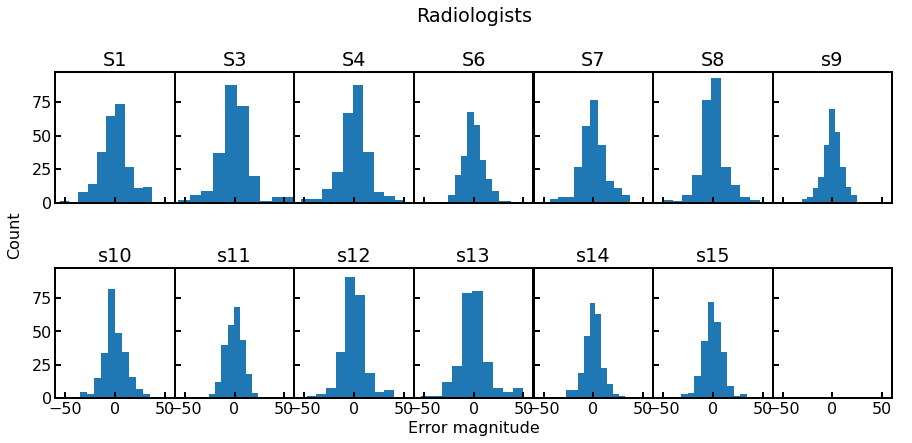

In [77]:
df_percentiles = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])
alldata = pd.DataFrame()

row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()
subject_names_wsuper = subject_names[:-1]
for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    df_percentiles.loc[row,'SUBJECT'] = subject
    alldata[subject] = subjectdata['responseError']

    axs[row].hist(subjectdata['responseError'])
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)

    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n')

## Subject loop with new JND

In [46]:
n_bins=50

In [47]:
def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram (data, bins=n_bins, normed=True)
    cdf = np.cumsum (counts)
    cdf_values = data.value_counts().sort_index().cumsum() / data.shape[0]
    print(cdf_values)
    cdf_percentile_25 = np.percentile(np.sort(cdf_values.index), 25) 
    cdf_percentile_75 = np.percentile(np.sort(cdf_values.index), 75) 
    
    fig,ax = plt.subplots()
    ax.hist(data, alpha=0.5, bins=50, color='lightblue')
    ax.set_xlim([-73, 73])
    ax.set_ylabel('Frequency Histogram')
    ax.vlines(cdf_percentile_25, 0, 25, color='red')
    ax.vlines(cdf_percentile_75, 0, 25, color='green')

    ax2=ax.twinx()


    ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
    ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
    ax2.set_xlim([-73, 73])
    ax2.set_ylabel('CDF')
    plt.xlabel('Respose Error')
    plt.show()
#     print(bin_edges)
#     print(cdf_values.index)
    return cdf_values, cdf_percentile_25, cdf_percentile_75

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-55.422080    0.004
-35.363278    0.008
-34.506615    0.012
-33.413124    0.016
-33.355329    0.020
              ...  
 33.012205    0.984
 33.897536    0.988
 34.473975    0.992
 36.877072    0.996
 37.594439    1.000
Name: responseError, Length: 247, dtype: float64


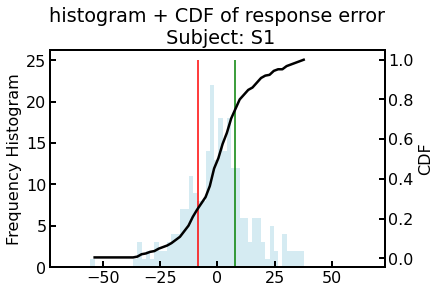

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-56.938985    0.004115
-51.997591    0.008230
-44.408201    0.012346
-42.991311    0.016461
-40.204022    0.020576
                ...   
 48.098394    0.983539
 51.933738    0.987654
 54.045569    0.991770
 56.314648    0.995885
 61.380379    1.000000
Name: responseError, Length: 239, dtype: float64


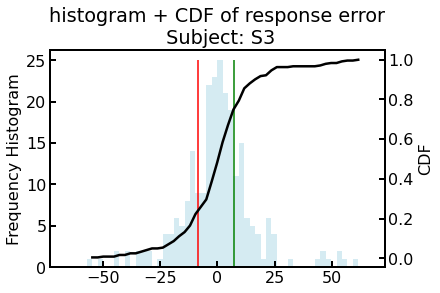

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-53.480202    0.004049
-47.756784    0.008097
-45.837405    0.012146
-38.020704    0.016194
-36.542805    0.020243
                ...   
 33.635427    0.983806
 35.357888    0.987854
 39.125196    0.991903
 44.118616    0.995951
 51.118616    1.000000
Name: responseError, Length: 243, dtype: float64


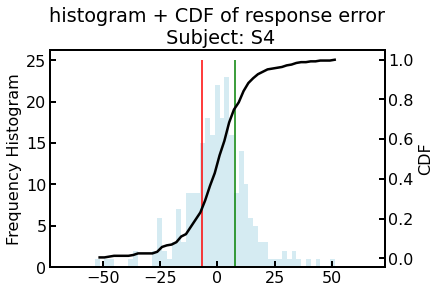

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-25.378196    0.004016
-23.906509    0.008032
-22.274469    0.012048
-21.919862    0.016064
-20.038303    0.020080
                ...   
 22.780620    0.983936
 22.844169    0.987952
 24.901059    0.991968
 26.435166    0.995984
 37.811531    1.000000
Name: responseError, Length: 243, dtype: float64


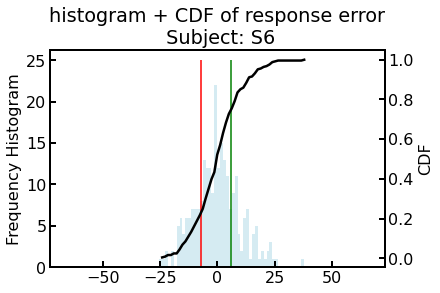

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-43.626598    0.004032
-43.330480    0.008065
-38.190012    0.012097
-31.796400    0.016129
-29.031638    0.020161
                ...   
 30.155105    0.983871
 32.163856    0.987903
 33.687901    0.991935
 35.284882    0.995968
 37.342362    1.000000
Name: responseError, Length: 246, dtype: float64


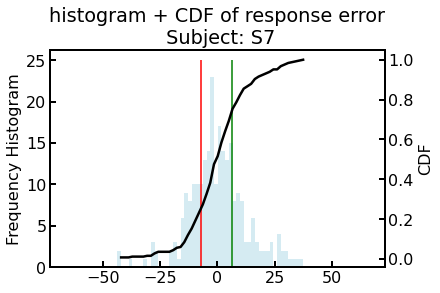

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-50.030450    0.004065
-43.286294    0.008130
-33.053756    0.012195
-30.053756    0.016260
-28.794480    0.020325
                ...   
 30.909209    0.983740
 34.047810    0.987805
 37.277035    0.991870
 37.341496    0.995935
 47.009044    1.000000
Name: responseError, Length: 240, dtype: float64


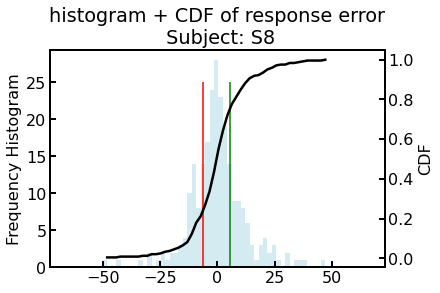

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.069045    0.004032
-27.322263    0.008065
-27.174489    0.012097
-23.280764    0.016129
-21.765192    0.020161
                ...   
 20.131852    0.983871
 22.564257    0.987903
 23.374367    0.991935
 23.849170    0.995968
 24.377390    1.000000
Name: responseError, Length: 245, dtype: float64


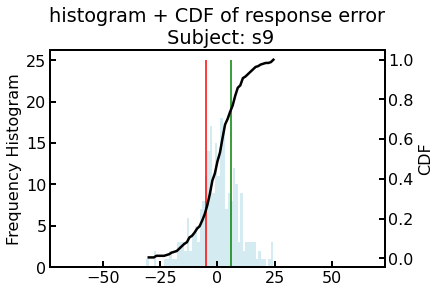

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-35.110646    0.004016
-33.441823    0.008032
-30.011875    0.012048
-28.482783    0.016064
-28.125461    0.020080
                ...   
 25.781342    0.983936
 27.492434    0.987952
 29.804841    0.991968
 32.345982    0.995984
 35.009332    1.000000
Name: responseError, Length: 247, dtype: float64


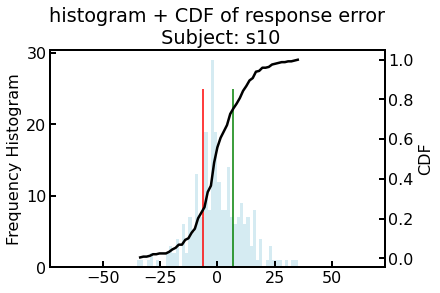

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.759483    0.004065
-22.776480    0.008130
-22.534022    0.012195
-20.956791    0.016260
-17.833167    0.020325
                ...   
 18.223520    0.983740
 18.796045    0.987805
 20.318836    0.991870
 23.753823    0.995935
 30.107082    1.000000
Name: responseError, Length: 238, dtype: float64


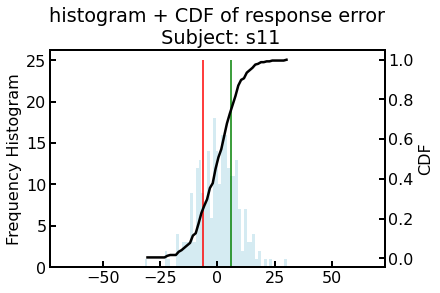

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-47.661598    0.004049
-45.401729    0.008097
-37.443261    0.012146
-36.834658    0.016194
-31.986442    0.020243
                ...   
 34.477627    0.983806
 37.281224    0.987854
 38.503049    0.991903
 39.280015    0.995951
 49.756415    1.000000
Name: responseError, Length: 245, dtype: float64


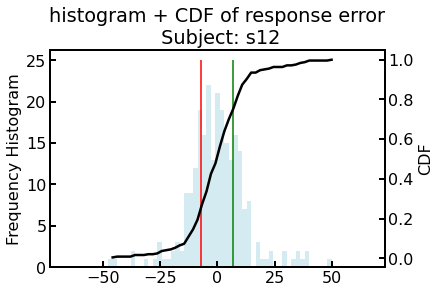

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-52.760577    0.004049
-48.342759    0.008097
-37.980176    0.012146
-33.157418    0.016194
-31.228004    0.020243
                ...   
 45.509119    0.983806
 46.556573    0.987854
 49.145122    0.991903
 49.646653    0.995951
 49.918081    1.000000
Name: responseError, Length: 246, dtype: float64


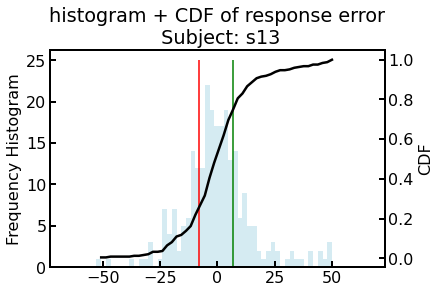

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-27.650774    0.003984
-26.986684    0.007968
-26.547455    0.011952
-22.862040    0.015936
-22.668335    0.019920
                ...   
 20.481589    0.984064
 21.541539    0.988048
 24.011284    0.992032
 26.697329    0.996016
 32.019272    1.000000
Name: responseError, Length: 247, dtype: float64


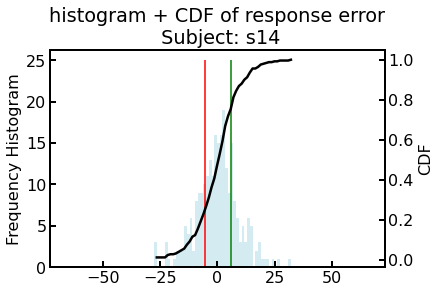

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-31.663909    0.004082
-29.904570    0.008163
-28.435451    0.012245
-24.141551    0.016327
-23.267018    0.020408
                ...   
 18.727677    0.979592
 22.428909    0.987755
 28.336091    0.991837
 31.787647    0.995918
 34.054756    1.000000
Name: responseError, Length: 238, dtype: float64


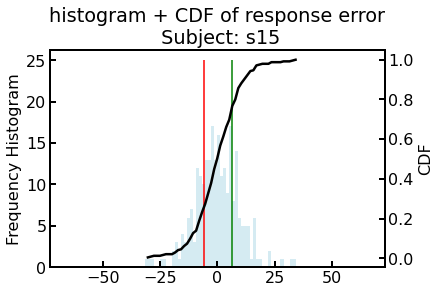

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Passing `normed=True` on non-uniform bins has always been broken, and computes neither the probability density function nor the probability mass function. The result is only correct if the bins are uniform, when density=True will produce the same result anyway. The argument will be removed in a future version of numpy.
  


-52.974024    0.000312
-50.268412    0.000624
-48.735944    0.000936
-46.980999    0.001248
-46.971263    0.001560
                ...   
 43.795603    0.998752
 45.264065    0.999064
 48.264065    0.999376
 49.892916    0.999688
 52.264065    1.000000
Name: responseError, Length: 2431, dtype: float64


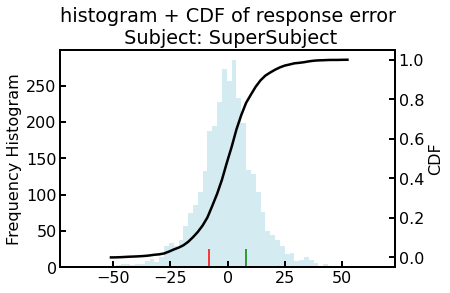

In [48]:
cdf_data = pd.DataFrame(columns=['SUBJECT','0TH','50TH'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    cdf, cdf_percentile_25, cdf_percentile_75 = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = (cdf_percentile_75- cdf_percentile_25)/2
    
    
    row += 1

Text(0.5, 1.0, 'Continuous Report Discrimination (CRD) per subject')

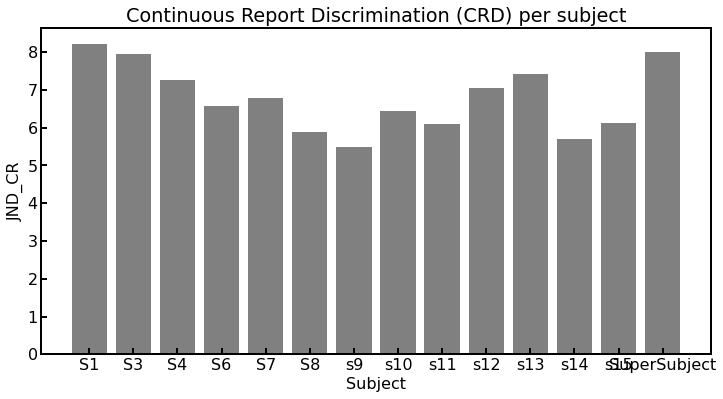

In [49]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) per subject')

In [50]:
cdf.index

Float64Index([ -52.97402422811504, -50.268411921528006, -48.735944467722696,
               -46.98099878281186,  -46.97126274826624,  -46.14450572723396,
                -45.0018409603509,  -44.88172051087496,  -44.40289568305794,
               -44.07626786535475,
              ...
               41.025975771884966,   41.31694505261641,   42.31070468207519,
               42.459176010378265,   42.98438096425392,   43.79560261483349,
                45.26406492918361,   48.26406492918361,   49.89291626307702,
                52.26406492918361],
             dtype='float64', length=2431)

## Steeper function 

In [51]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def calculate_and_plot_cdf(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    counts_filtered = counts.copy()
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    bestvals, temp = curve_fit(sigmoid,bin_edges[1:],cdf_filtered,p0=[5])

    perc_25 = inverse_sigmoid(0.25, bestvals)
    perc_75 = inverse_sigmoid(0.75, bestvals)
    
    plt.plot(bin_edges[1:], cdf, color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals), color='blue', linewidth=2.5,label='filtered')
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75 - perc_25)/2
#     ax2.plot (bin_edges[1:], cdf/cdf[-1], color='black', linewidth=2.5)
#     ax2.set_title('histogram + CDF of response error\n Subject: ' + title)
#     ax2.set_xlim([-73, 73])
#     ax2.set_ylabel('CDF')
#     plt.xlabel('Respose Error')
#     plt.show()
# #     print(bin_edges)
# #     print(cdf_values.index)
#     return cdf_values, cdf_percentile_25, cdf_percentile_75

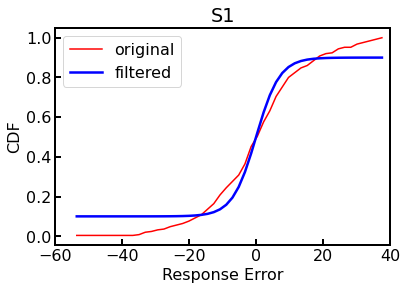

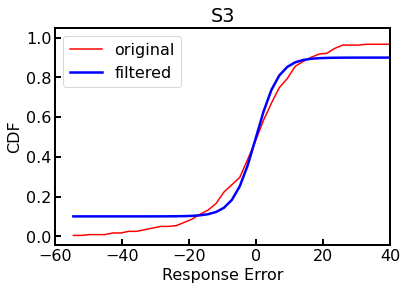

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


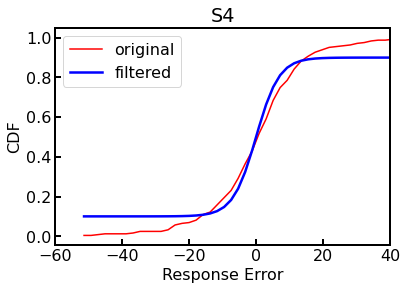

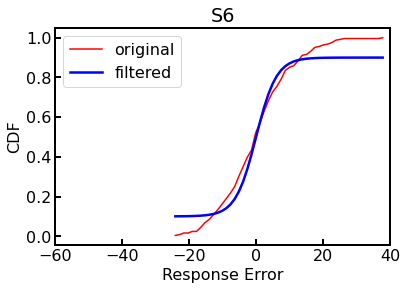

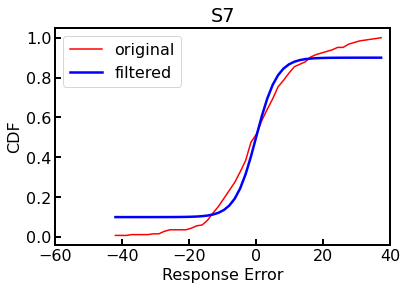

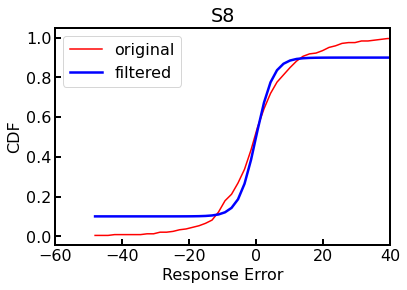

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


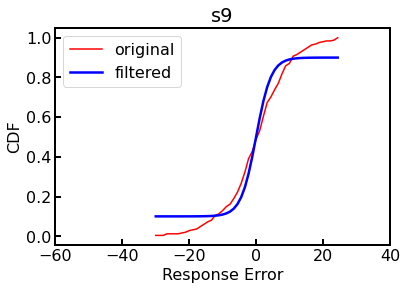

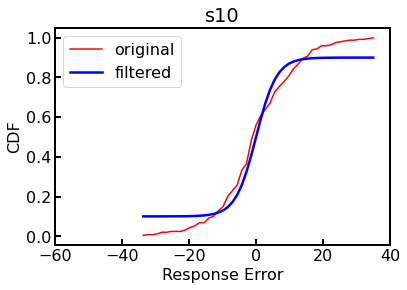

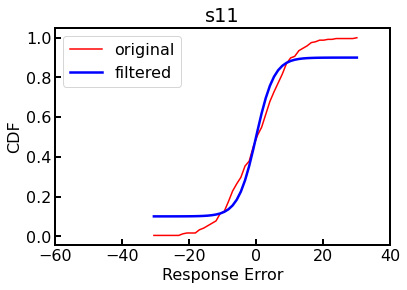

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


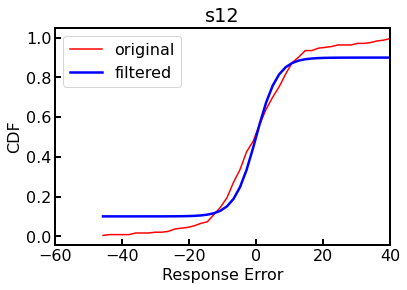

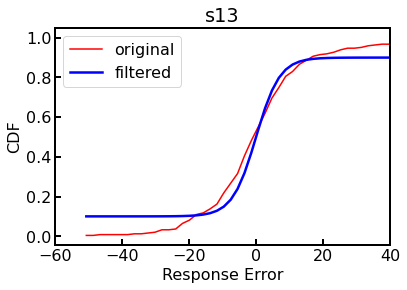

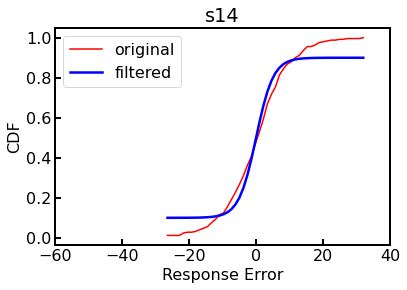

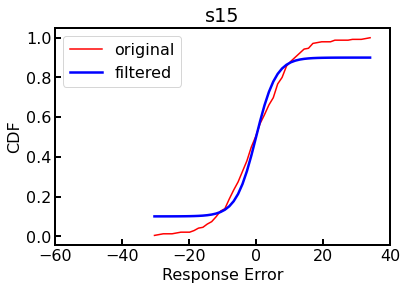

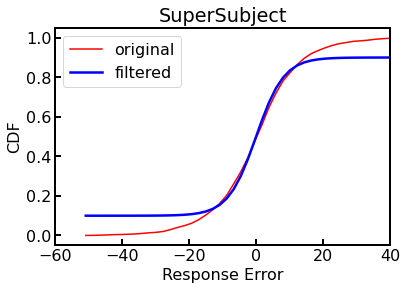

In [52]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_CR'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

#     cdf_filtered_sub = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    
    jnd_cr = calculate_and_plot_cdf(subjectdata['responseError'], title=subject)
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_CR'] = jnd_cr[0]
    
    
    row += 1

In [53]:
cdf_data

,SUBJECT,JND_CR
0,S1,5.146075
1,S3,4.921389
2,S4,5.059302
3,S6,4.469861
4,S7,4.597411
5,S8,3.741497
6,s9,3.287051
7,s10,4.462661
8,s11,3.947852
9,s12,4.728421


Text(0.5, 1.0, 'Continuous Report Discrimination (CRD) v2 per subject')

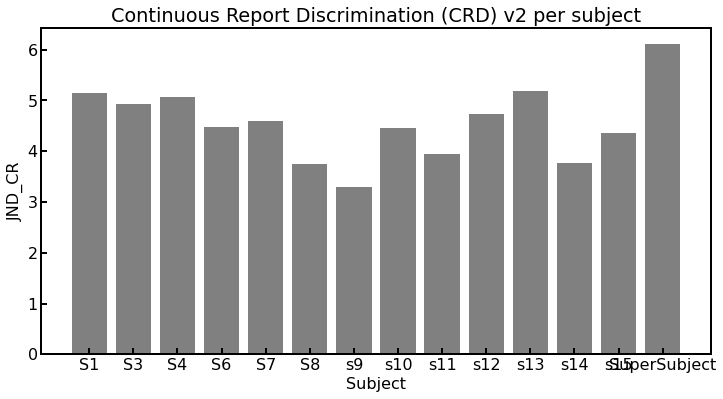

In [54]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CR'], color='gray')
plt.ylabel('JND_CR')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) v2 per subject')

# Gaussian & Cauchy distribution 

## Define functions 

In [55]:
# data = np.asarray(alldata['S1'])
# counts, bin_edges = np.histogram(data, bins=n_bins)

In [56]:
def sigmoid(x,a):
    return 0.8/(1+np.exp(-a*x)) + 0.1

def inverse_sigmoid(y, a):
    return -math.log(0.8/(y-0.1)-1)/a

def gaussian(x, amplitude, mean, stddev):
    return amplitude * np.exp(-(x-mean)**2/(2*stddev**2))

def gaussian_original(x, amplitude, mean, stddev):
    return amplitude * ((1/(stddev*np.sqrt(2*np.pi))) * np.exp((-1/2)*(((x-mean)**2)/(stddev**2))))

def cauchy(x, gamma, amplitude, mean):
    return (1/(np.pi*gamma*(1+((x-mean)/gamma)**2)))*amplitude

def vm(x, mean, kai, amplitude):
    x = (x/53)*np.pi
    return amplitude * (np.exp(kai * np.cos(x-mean)) / (i0(kai) * 2 * np.pi))
                  
def cdf(counts):
    cdf = np.cumsum (counts)
    cdf = cdf/cdf[-1]
    
    counts_filtered = counts.copy()
    counts_filtered[counts_filtered < 5] = 0
    cdf_filtered = np.cumsum (counts_filtered)
    c = cdf_filtered.copy()
    cdf_filtered = cdf_filtered/cdf_filtered[-1]
    

        
    
    return cdf, cdf_filtered, counts_filtered
    
def cdf_gaussian_cauchy(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    
    if title=='SuperSubject':
        counts = counts/13
    
    cdf_og, cdf_filtered_og, counts_filtered_og = cdf(counts)
    
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
#     print(popt_gaussian)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:,], *popt_vm)
    
    cdf_cauchy, cdf_filtered_cauchy, counts_cauchy_filtered = cdf(counts_cauchy)
    cdf_gaussian, cdf_filtered_gaussian, counts_gaussian_filtered = cdf(counts_gaussian)
    cdf_vm, cdf_filtered_vm, counts_vm_filtered = cdf(counts_vm)
    
    
    bestvals_og, temp_og = curve_fit(sigmoid,bin_edges[1:],cdf_og,p0=[5])
    bestvals_cauchy, temp_cauchy = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_cauchy,p0=[5])
    bestvals_gaussian, temp_gaussian = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_gaussian,p0=[5])
    bestvals_vm, temp_vm = curve_fit(sigmoid,bin_edges[1:],cdf_filtered_vm,p0=[5])
    
    perc_25_og = inverse_sigmoid(0.25, bestvals_og)
    perc_75_og = inverse_sigmoid(0.75, bestvals_og)
        
    perc_25_cauchy = inverse_sigmoid(0.25, bestvals_cauchy)
    perc_75_cauchy = inverse_sigmoid(0.75, bestvals_cauchy)
    
    perc_25_gaussian = inverse_sigmoid(0.25, bestvals_gaussian)
    perc_75_gaussian = inverse_sigmoid(0.75, bestvals_gaussian)

    perc_25_vm = inverse_sigmoid(0.25, bestvals_vm)
    perc_75_vm = inverse_sigmoid(0.75, bestvals_vm)    
    
    plt.plot(bin_edges[1:], cdf_og, color='red', linewidth=1.5, label='original')
#     plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_og), color='red', linewidth=1.5, label='original')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_cauchy), color='blue', linewidth=2.5,label='cauchy')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_gaussian), color='green', linewidth=2.5,label='gaussian')
    plt.plot(bin_edges[1:], sigmoid(bin_edges[1:], bestvals_vm), color='purple', linewidth=2.5,label='vm')
    
    plt.xlim([-60, 40])
    plt.ylabel('CDF')
    plt.xlabel('Response Error')
    plt.legend()
    plt.title(title)
    plt.show()
    
    return (perc_75_og - perc_25_og)/2, (perc_75_gaussian - perc_25_gaussian)/2, (perc_75_cauchy - perc_25_cauchy)/2, (perc_75_vm - perc_25_vm)/2


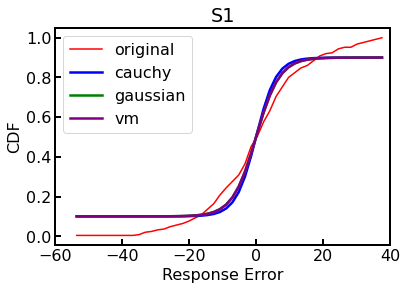

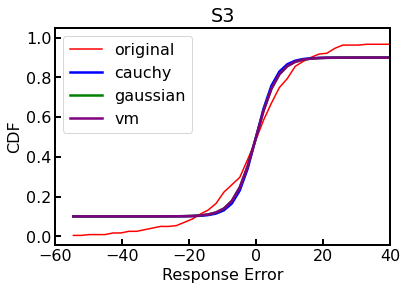

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


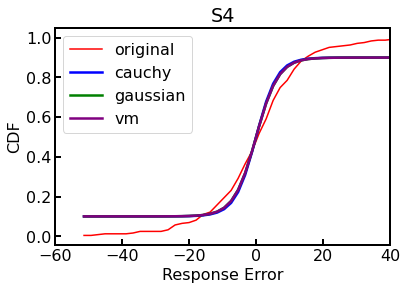

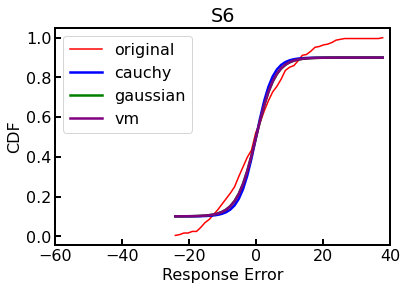

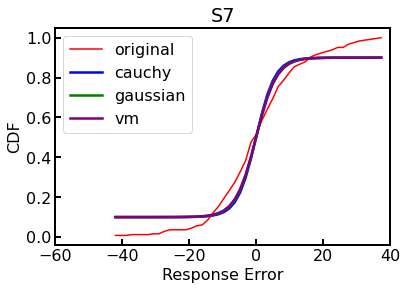

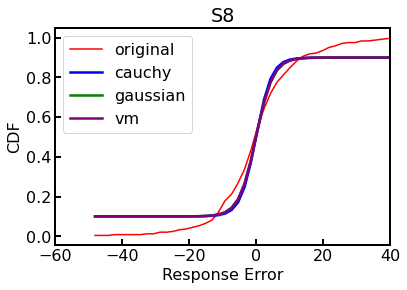

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


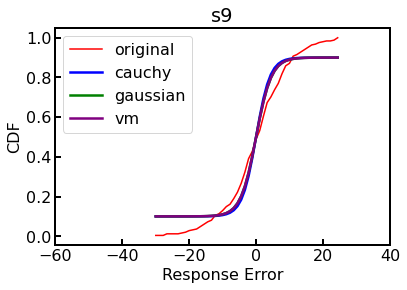

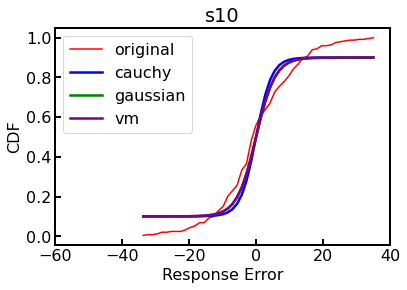

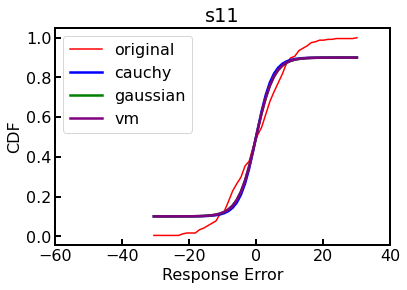

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


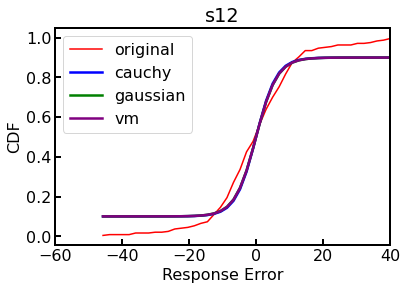

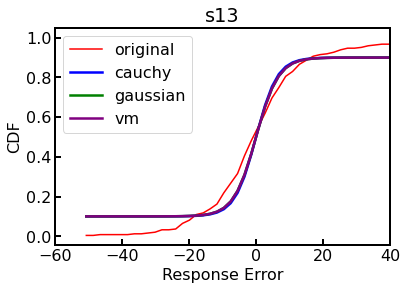

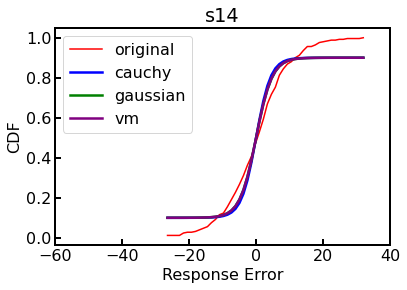

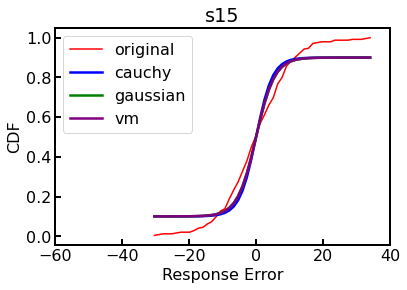

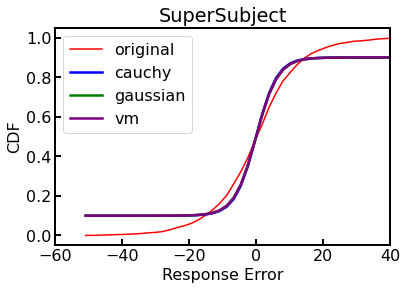

In [57]:
cdf_data = pd.DataFrame(columns=['SUBJECT','JND_OG',  'JND_GAUSSIAN', 'JND_CAUCHY'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    jnd_og, jnd_gaussian, jnd_cauchy, jnd_vm = cdf_gaussian_cauchy(subjectdata['responseError'], title=subject)
    
    cdf_data.loc[row,'SUBJECT'] = subject
    cdf_data.loc[row, 'JND_OG'] = jnd_og[0]
    cdf_data.loc[row, 'JND_GAUSSIAN'] = jnd_gaussian[0]
    cdf_data.loc[row, 'JND_CAUCHY'] = jnd_cauchy[0]
    cdf_data.loc[row, 'JND_VM'] = jnd_vm[0]
    
    row += 1

(0.0, 5.5)

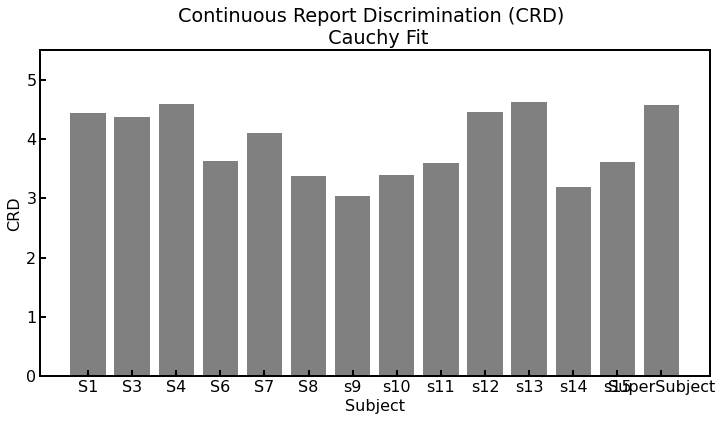

In [58]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_CAUCHY'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Cauchy Fit')
plt.ylim([0, 5.5])

(0.0, 5.5)

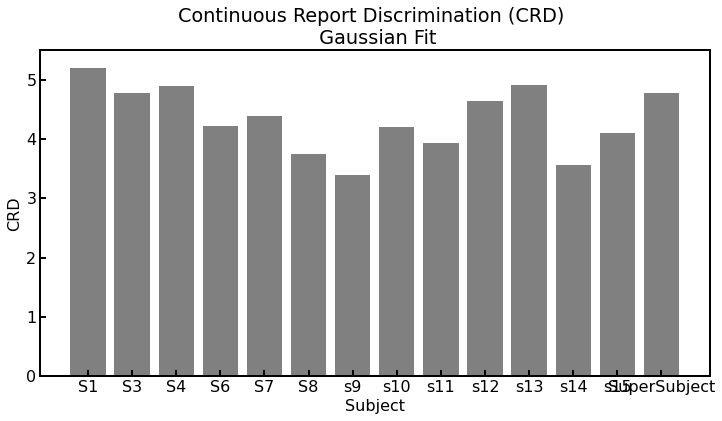

In [59]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_GAUSSIAN'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n Gaussian Fit')
plt.ylim([0, 5.5])

In [60]:
np.median(cdf_data['JND_VM'])

4.353146154403766

In [61]:
np.median(cdf_data['JND_CAUCHY'])

3.868380849383473

In [62]:
np.median(cdf_data['JND_GAUSSIAN'])

4.303122019927733

(0.0, 5.5)

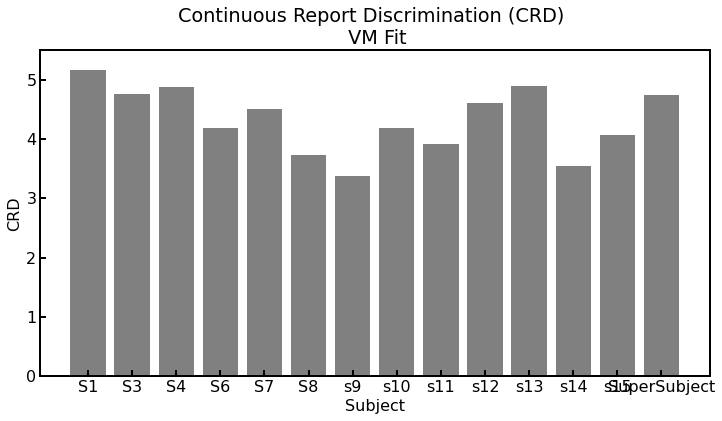

In [63]:
plt.figure(figsize=(12,6))
plt.bar(cdf_data['SUBJECT'],  cdf_data['JND_VM'], color='gray')
plt.ylabel('CRD')
plt.xlabel('Subject')
plt.title('Continuous Report Discrimination (CRD) \n VM Fit')
plt.ylim([0, 5.5])

## Goodness of fit 

Here, yi refers to your input y-values, fi refers to your fitted y-values, and ̅y refers to the mean input y-value.

In [64]:
# residual sum of squares
def r2(x, y,  y_fit, title):
#     weight_param = 1/(abs(x)+1)
#     plt.plot((y - y_fit) ** 2)
#     plt.ylim([0, 2500])
#     plt.title(title)
#     plt.show()
    ss_res = np.sum(((y - y_fit) ** 2))
    
    # total sum of squares
    ss_tot = np.sum(((y - np.mean(y)) ** 2))

    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def calculate_r2_subjects(data, title):
    counts, bin_edges = np.histogram(data, bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) #, p0=4, bounds= (0,np.inf))
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    
    counts_cauchy = cauchy(bin_edges[1:], *popt_cauchy)
    counts_gaussian = gaussian(bin_edges[1:], *popt_gaussian)
    counts_vm = vm(bin_edges[1:], *popt_vm)

    r2_fit_gaussian = r2(bin_edges[1:], counts, counts_cauchy, title+'Gaussian')
    r2_fit_cauchy = r2(bin_edges[1:], counts, counts_gaussian, title+'Cauchy')
    r2_fit_vm = r2(bin_edges[1:], counts, counts_vm, title+'VM')
    
    
    return r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm

In [65]:
r2_data = pd.DataFrame(columns=['SUBJECT','R2_GAUSSIAN', 'R2_CAUCHY', 'R2_VM'])

row = 0
for subject in subject_names:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]

    r2_fit_gaussian, r2_fit_cauchy, r2_fit_vm= calculate_r2_subjects(subjectdata['responseError'], subject)
    
    r2_data.loc[row,'SUBJECT'] = subject
    r2_data.loc[row, 'R2_GAUSSIAN'] = r2_fit_gaussian
    r2_data.loc[row, 'R2_CAUCHY'] = r2_fit_cauchy
    r2_data.loc[row, 'R2_VM'] = r2_fit_vm
    
    
    row += 1

In [66]:
r2_data_melted = r2_data.melt(id_vars=['SUBJECT'], value_vars=['R2_GAUSSIAN','R2_CAUCHY', 'R2_VM'])

Text(0, 0.5, 'R2')

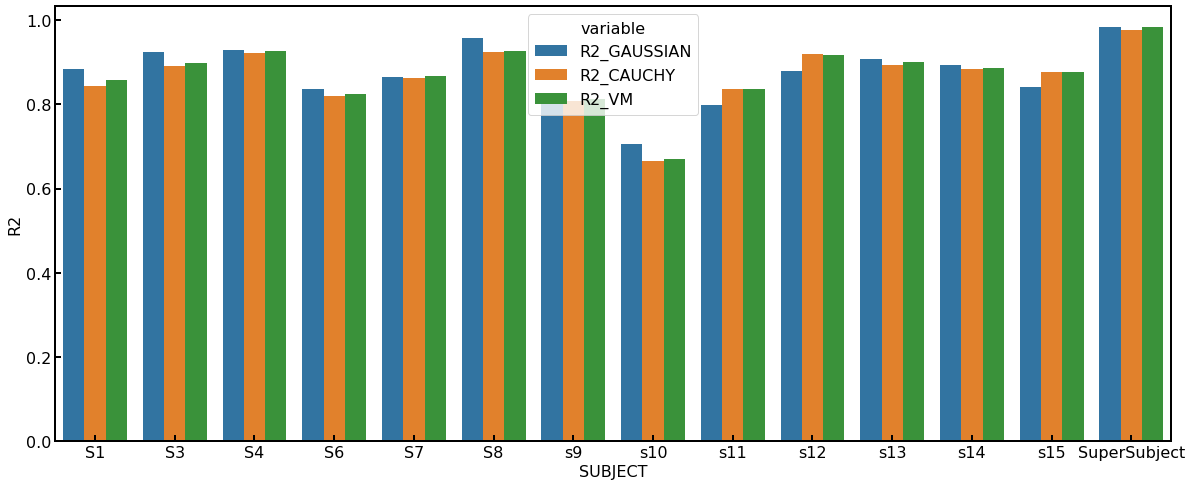

In [67]:
plt.figure(figsize=(20,8))
sns.barplot(x='SUBJECT', y='value', hue='variable', data=r2_data_melted)
plt.ylabel('R2')


## Comparing fits 

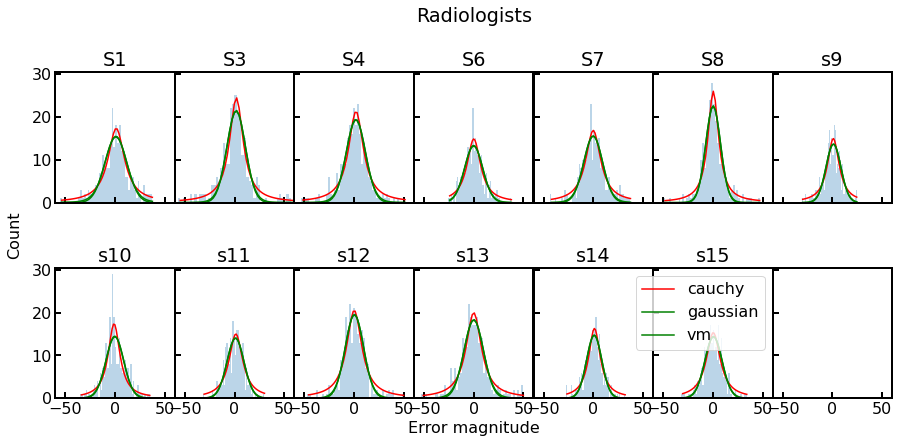

In [68]:
row = 0
fig, axs = plt.subplots(2,7, figsize=(15, 6), facecolor='w', edgecolor='k', sharex=True, sharey=True)
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.add_subplot(111, frameon=False)

axs = axs.ravel()

for subject in subject_names_wsuper:
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)]
    counts, bin_edges = np.histogram(subjectdata['responseError'], bins=n_bins)
    popt_cauchy, _ = curve_fit(cauchy, bin_edges[1:], counts) 
    popt_gaussian, _ = curve_fit(gaussian, bin_edges[1:], counts)
    popt_vm, _ = curve_fit(vm, bin_edges[1:], counts)
    axs[row].hist(subjectdata['responseError'], bins=n_bins, alpha=0.3)
    axs[row].plot(bin_edges[1:], cauchy(bin_edges[1:], *popt_cauchy), color='red', label='cauchy')
    axs[row].plot(bin_edges[1:], gaussian(bin_edges[1:], *popt_gaussian), color='green', label='gaussian')
    axs[row].plot(bin_edges[1:], vm(bin_edges[1:], *popt_vm), color='green', label='vm')
    axs[row].set_xlabel('')
    axs[row].set_ylabel('')
    axs[row].set_xlim([-60, 60])
    axs[row].set_title(subject)
    
    if subject == 's15':
        axs[row].legend()
    
    row += 1
plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
plt.xlabel('Error magnitude')
plt.ylabel('Count')
plt.title('Radiologists\n\n');
# plt.legend()


# Correlation slopes and JND 

In [69]:
# slopes = pd.read_csv(figures_path + '/RegressionSlope_radiologists/subject_slopes.csv', index_col=0)

In [70]:
# corr_df = pd.DataFrame()
# row=0
# for ntype in slopes.NTYPE.unique():
    
#     r_value, p_value = stats.pearsonr(slopes.loc[slopes['NTYPE'] == ntype, 'BOOTSTRAP_MEAN'], cdf_data[:-1]['JND_CR'])
#     corr_df.loc[row, 'NTYPE'] = ntype
#     corr_df.loc[row, 'R_VALUE'] = r_value
#     corr_df.loc[row, 'P_VALUE'] = p_value
    
#     row+=1

KeyError: 'JND_CR'

# Category boundaries 

## First version

In [101]:
perc_extreme_df = pd.DataFrame()
for i, subject in enumerate(subject_names_wsuper):
    
    # load data:
    subjectdata = pd.read_csv(datapath + subject + '/' + subject + '_VM_output_1nBack.csv')
    subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)
#     display(subjectdata)
    
    perc_extreme = np.sum(abs(subjectdata['responseError']) > abs(subjectdata['Stim_diff']))/len(subjectdata)
    perc_extreme_df.loc[i, 'SUBJECT'] = subject
    perc_extreme_df.loc[i,'PERC_EXTREME'] = perc_extreme*100
#     print(perc_extreme)


In [102]:
perc_extreme_df

,SUBJECT,PERC_EXTREME
0,S1,14.800000
1,S3,16.049383
2,S4,14.170040
3,S6,10.040161
4,S7,12.500000
5,S8,12.601626
6,s9,10.887097
7,s10,8.835341
8,s11,11.382114
9,s12,12.550607


Text(0, 0.5, '%')

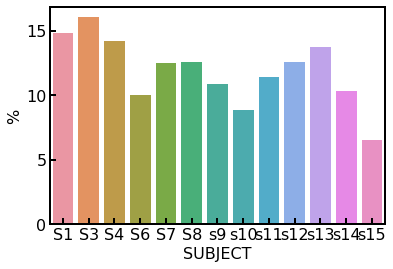

In [105]:
sns.barplot(x='SUBJECT', y='PERC_EXTREME', data=perc_extreme_df)
plt.ylabel('%')

In [100]:
min(subjectdata['responseError'])

-31.66390939098087

In [106]:
np.median(perc_extreme_df['PERC_EXTREME'])

12.5

## Second version

In [140]:
def vonmise_derivative(xdata, a = 25, kai = 4):
    xdata = xdata / 75 * np.pi
    return - a / (i0(kai) * 2 * np.pi) * exp(kai * cos(xdata)) * kai * sin(xdata) # Derivative of vonmise formula
def getRunningMean(stimuli_diff, filtered_responseError, halfway =74, step = 8):
    RM = [None] * (2 * halfway + 1); # running mean initialization
    xvals = list(range(-halfway, halfway + 1)) # index for running mean -90~90 + -90~90 (avoid error in sep[jj] == 91\92...
    allx_vals = xvals + xvals
    for ii in range(0,len(xvals) - 1): # start running mean calculation 0~180
        if ii - step // 2 >= 0:
            sep = allx_vals[(ii - step // 2) : (ii + step // 2 + 1)] # symmetric to avoid shift
        else:
            sep = allx_vals[(ii - step // 2) : len(allx_vals)] + allx_vals[0 : (ii + step // 2 + 1)]
        sep_sum = []
        for jj in range(0,len(sep)): # match every value in sep to every stimuli_diff point
            for kk in range(0, len(stimuli_diff)):
                if stimuli_diff[kk] == sep[jj]:
                    sep_sum.insert(0, filtered_responseError[kk])
        RM[ii] = np.mean(sep_sum)
    RM[2 * halfway] = RM[0]
    return RM, xvals

def getRegressionLine(x, y, peak):
    stimuli_diff_filtered = []
    filtered_responseError_new = []
    for i in range(len(x)):
        if x[i] < peak + 1 and x[i] > - peak + 1:
            stimuli_diff_filtered.append(x[i])
            filtered_responseError_new.append(y[i])
    coef = np.polyfit(stimuli_diff_filtered,filtered_responseError_new,1)
    poly1d_fn = np.poly1d(coef)
    return poly1d_fn, coef

In [123]:
def category_definition(morph):
    
    if (morph in range(124, 148)) or (morph in range(1, 26)):
        category = 'A'
    elif morph in range(26, 75):
        category = 'B'
    elif morph in range(75, 124):
        category = 'C'
        
    return category

In [146]:
# category_df = pd.DataFrame()
# for i, subject in enumerate(subject_names_wsuper):
# subjectdata['SUBJECT'] = subject
# category_df = pd.concat([category_df, subjectdata[['SUBJECT', 'same_category', 'responseError', 'Stim_diff']]], axis=0)


# load data:
subjectdata = pd.read_csv(datapath + 'SuperSubject' + '/' + 'SuperSubject' + '_VM_output_1nBack.csv')
subjectdata = subjectdata[(subjectdata['trialNumber'] >=1) & (subjectdata['trialNumber'] <=84)].reset_index(drop=True)


subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)
display(subjectdata)

same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)


,stimulusID,morphID,RT,trialNumber,blockNumber,stimLocationDeg,shifted_stimulusID,shifted_stimLocationDeg,shifted_morphID,Error,responseError,Stim_diff,Stim_Loc_diff,bootstrap_values,Running_Mean,slopes,intercepts,DoVM,same_category
0,67.0,72.0,2.899034,1.0,1.0,199.0,58.0,0.0,70.0,12.0,12.899911,9.0,-161.0,2.877162,-0.145858,0.213787,-0.141277,-0.009954,True
1,58.0,70.0,2.149815,2.0,1.0,0.0,57.0,331.0,76.0,19.0,19.925233,1.0,29.0,2.262816,-0.058473,0.174345,-0.210180,-0.015040,True
2,133.0,78.0,4.315844,4.0,1.0,235.0,135.0,277.0,143.0,8.0,4.903950,-2.0,-42.0,2.659032,-0.029940,0.179925,-0.295605,-0.020258,True
3,135.0,143.0,3.183391,5.0,1.0,277.0,127.0,29.0,144.0,17.0,20.953967,8.0,-112.0,3.245064,-0.092737,0.234082,-0.780027,-0.025656,True
4,127.0,144.0,1.099883,6.0,1.0,29.0,25.0,171.0,26.0,1.0,3.376916,-44.0,-142.0,3.151687,-0.471416,0.243161,-0.107494,-0.031280,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,40.0,31.0,6.183971,80.0,3.0,4.0,37.0,132.0,44.0,7.0,6.468113,3.0,-128.0,3.049295,NaN,0.244890,-0.819643,NaN,True
3202,37.0,44.0,1.299518,81.0,3.0,132.0,122.0,250.0,117.0,-5.0,2.795603,61.0,-118.0,2.894830,NaN,0.210273,-0.059963,NaN,False
3203,122.0,117.0,3.114310,82.0,3.0,250.0,76.0,205.0,81.0,5.0,-0.974024,46.0,45.0,2.764708,NaN,0.175108,0.026957,NaN,True
3204,76.0,81.0,3.432437,83.0,3.0,205.0,147.0,140.0,7.0,6.0,8.117835,-71.0,65.0,1.961655,NaN,0.108449,-0.052763,NaN,False


/opt/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


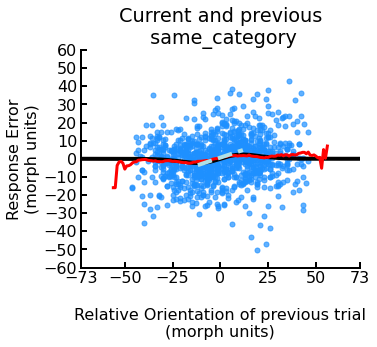

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


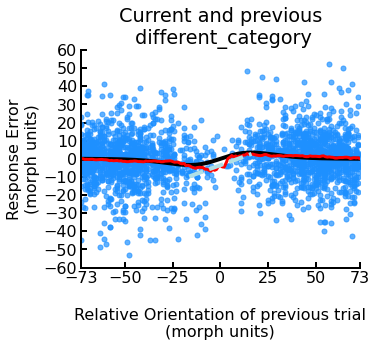

In [284]:
def amplitude_calc(data, title):
    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals, bounds = ([-60,2],[60,4]))
    #### RUNNING MEAN ####
    RM, xvals = getRunningMean(data['Stim_diff'], data['responseError'], step = 20)

    plt.figure(figsize=(5, 4))
    plt.plot(data['Stim_diff'], data['responseError'], color='dodgerblue', marker='o', linestyle='none', alpha=0.7, markersize=5)
    x = np.linspace(-75, 75, 300)
    y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]
    DoVM_values = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in data['Stim_diff']]
    plt.plot(x, y, '-', linewidth = 4, color='k')
    plt.plot(xvals, RM, label = 'Running Mean', color = 'red', linewidth = 3)
    peak_x = (x[np.argmax(y)])
    poly1d_fn, coef = getRegressionLine(x = data['Stim_diff'], y= data['responseError'], peak = peak_x)
    xdata = np.linspace(-peak_x, peak_x, 100)
    plt.plot(xdata, poly1d_fn(xdata), linestyle='--', color='powderblue', linewidth = 4)
    plt.xlim([-73, 73])
    plt.ylim([-60, 60])
    plt.yticks(np.arange(-60, 70, 10))
    # plt.xticks(np.arange(-70, 80, 20))
    plt.xticks([-73, -50, -25, 0, 25, 50, 73])
    sns.despine()
    # print(coef[0], coef[1])
    plt.title('Current and previous\n ' + title)
    plt.ylabel('Response Error\n(morph units)')
    plt.xlabel('\nRelative Orientation of previous trial\n(morph units)')
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.eps', bbox_inches='tight', dpi=1200)
    plt.savefig('RunningMean_DOGfit_Radiologists' + title + '.jpg', bbox_inches='tight', dpi=1200)
    plt.show()

    return np.max(y)

empirical_amp_same_category = amplitude_calc(same_category, 'same_category')
empirical_amp_diff_category = amplitude_calc(diff_category, 'different_category')
    

In [332]:
def permute_null(data, nIterations=5000):
    data_null = pd.DataFrame()
    for iteration in range(nIterations):
        print(iteration)
        stim_diff = data['Stim_diff'].sample(frac=1).reset_index(drop=True)

        ## Von Mise fitting: Shape Similarity##
        init_vals = [-25, 4]
        try: 
            best_vals, covar = curve_fit(vonmise_derivative, stim_diff, data['responseError'], p0=init_vals,bounds = ([-60,2],[60,4]))
            x = np.linspace(-75, 75, 300)
            y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]

            data_null.loc[iteration, 'ITERATION'] = iteration
            
            if x[np.argmax(y)] > 0: 
                amplitude = np.max(y)
            else: 
                amplitude = -np.max(y)
            data_null.loc[iteration, 'AMPLITUDE'] = amplitude
            #### RUNNING MEAN ####
#         RM, xvals = getRunningMean(stim_diff, data['responseError'], step = 20)
        except RuntimeError:
            print("Error - curve_fit failed")

        
    return data_null
    
# def permute_null_v2(data, nIterations=1000):
#     data_null = pd.DataFrame()
#     for iteration in range(nIterations):
#         print(iteration)
        
#         stim_diff = np.asarray(data['Stim_diff'])
#         response_error = np.asarray(data['responseError'])
#         np.random.shuffle(stim_diff)
        

#         ## Von Mise fitting: Shape Similarity##
#         init_vals = [-25, 4]
#         try: 
#             best_vals, covar = curve_fit(vonmise_derivative, stim_diff, response_error, p0=init_vals,bounds = ([-60,2],[60,4]))
#             x = np.linspace(-75, 75, 300)
#             y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]

#             data_null.loc[iteration, 'ITERATION'] = iteration
#             data_null.loc[iteration, 'AMPLITUDE'] = np.max(y)
#             #### RUNNING MEAN ####
# #         RM, xvals = getRunningMean(stim_diff, data['responseError'], step = 20)
#         except RuntimeError:
#             print("Error - curve_fit failed")

        
#     return data_null
    


In [333]:
load = False
if load:
    same_category_null = pd.read_csv('same_category_null.csv')
    same_category_null.head()
else:
    
    same_category_null = permute_null(same_category)
    same_category_null.to_csv('same_category_null.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


<AxesSubplot:xlabel='AMPLITUDE'>

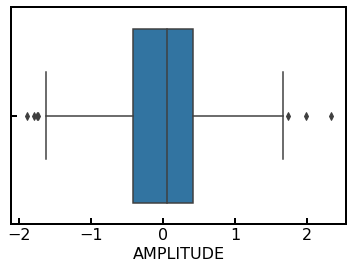

In [334]:
sns.boxplot(same_category_null['AMPLITUDE'])

(-3.0, 10.0)

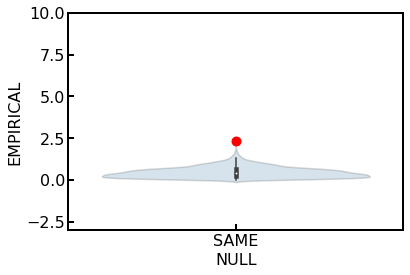

In [287]:
# clipped_same_category_null = outlier_clipping(same_category_null, 'AMPLITUDE')
same_category_null['NULL'] = 'SAME'
ax = sns.violinplot(data=same_category_null, x='NULL', y='AMPLITUDE')
for violin, alpha in zip(ax.collections[::2], [0.2]):
    violin.set_alpha(alpha)
emp_same = pd.DataFrame()
emp_same.loc[0, 'NULL'] = 'SAME'
emp_same.loc[0, 'EMPIRICAL'] = empirical_amp_same_category
sns.swarmplot(x = 'NULL', y='EMPIRICAL', data=emp_same, color='red', size=10)
plt.ylim([-3, 10])

# plt.axvline(x=empirical_amp_same_category)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060
2061
2062


3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699
3700
3701


<AxesSubplot:xlabel='AMPLITUDE'>

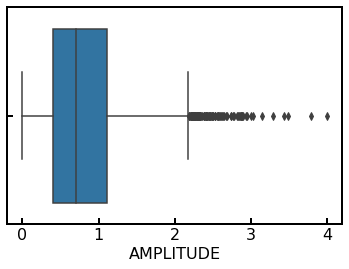

In [252]:
load = False
if load:
    diff_category_null = pd.read_csv('diff_category_null.csv')
else:
    diff_category_null = permute_null(diff_category)
    diff_category_null.to_csv('diff_category_null.csv')
    
sns.boxplot(diff_category_null['AMPLITUDE'])

(-3.0, 10.0)

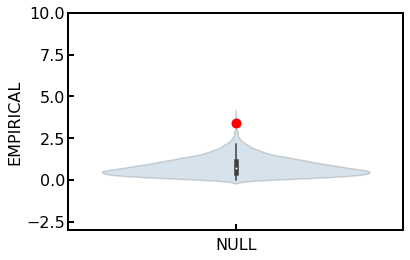

In [288]:
# clipped_diff_category_null = outlier_clipping(diff_category_null, 'AMPLITUDE')
diff_category_null['NULL'] = 'DIFFERENT'
ax = sns.violinplot(data=diff_category_null, x='NULL', y='AMPLITUDE')
for violin, alpha in zip(ax.collections[::2], [0.2]):
    violin.set_alpha(alpha)
emp_diff = pd.DataFrame()
emp_diff.loc[0, 'NULL'] = 'DIFFERENT'
emp_diff.loc[0, 'EMPIRICAL'] = empirical_amp_diff_category
sns.swarmplot(x = 'NULL', y='EMPIRICAL', data=emp_diff, color='red', size=10)
plt.xticks(range(1), '')
plt.ylim([-3, 10])
# plt.axvline(x=empirical_amp_same_category)

In [289]:
all_category_null = pd.concat([diff_category_null, same_category_null])
all_category_emp = pd.concat([emp_diff, emp_same])

Text(0.5, 1.0, 'Empirical vs null half amplitudes\nsame and different category')

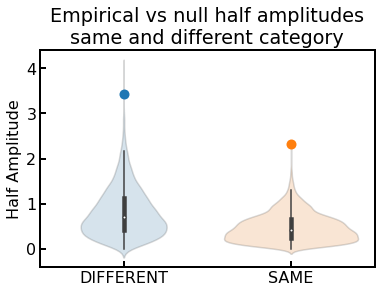

In [290]:
ax= sns.violinplot(x='NULL', y='AMPLITUDE', data=all_category_null)
for violin, alpha in zip(ax.collections[::2], [0.2, 0.2]):
    violin.set_alpha(alpha)
    
sns.swarmplot(x='NULL', y='EMPIRICAL', data=all_category_emp, size=10)
plt.xlabel('')
plt.ylabel('Half Amplitude')
plt.title('Empirical vs null half amplitudes\nsame and different category')

In [275]:
sorted_null_diff = sorted(diff_category_null['AMPLITUDE'])
ci97_null_diff = sorted_null_diff[int(nIterations*0.97)]
ci97_null_diff

2.0657191248705313

In [276]:
sorted_null_same = sorted(same_category_null['AMPLITUDE'])
ci97_null_same = sorted_null_same[int(nIterations*0.97)]
ci97_null_same

1.1593136636845114

In [274]:
len(sorted_null_diff)

10000

In [292]:
alldata_permuted_null = permute_null(subjectdata)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

1861
1862
1863
1864
1865
1866
1867
1868
1869
1870
1871
1872
1873
1874
1875
1876
1877
1878
1879
1880
1881
1882
1883
1884
1885
1886
1887
1888
1889
1890
1891
1892
1893
1894
1895
1896
1897
1898
1899
1900
1901
1902
1903
1904
1905
1906
1907
1908
1909
1910
1911
1912
1913
1914
1915
1916
1917
1918
1919
1920
1921
1922
1923
1924
1925
1926
1927
1928
1929
1930
1931
1932
1933
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
1945
1946
1947
1948
1949
1950
1951
1952
1953
1954
1955
1956
1957
1958
1959
1960
1961
1962
1963
1964
1965
1966
1967
1968
1969
1970
1971
1972
1973
1974
1975
1976
1977
1978
1979
1980
1981
1982
1983
1984
1985
1986
1987
1988
1989
1990
1991
1992
1993
1994
1995
1996
1997
1998
1999
2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023
2024
2025
2026
2027
2028
2029
2030
2031
2032
2033
2034
2035
2036
2037
2038
2039
2040
2041
2042
2043
2044
2045
2046
2047
2048
2049
2050
2051
2052
2053
2054
2055
2056
2057
2058
2059
2060


3500
3501
3502
3503
3504
3505
3506
3507
3508
3509
3510
3511
3512
3513
3514
3515
3516
3517
3518
3519
3520
3521
3522
3523
3524
3525
3526
3527
3528
3529
3530
3531
3532
3533
3534
3535
3536
3537
3538
3539
3540
3541
3542
3543
3544
3545
3546
3547
3548
3549
3550
3551
3552
3553
3554
3555
3556
3557
3558
3559
3560
3561
3562
3563
3564
3565
3566
3567
3568
3569
3570
3571
3572
3573
3574
3575
3576
3577
3578
3579
3580
3581
3582
3583
3584
3585
3586
3587
3588
3589
3590
3591
3592
3593
3594
3595
3596
3597
3598
3599
3600
3601
3602
3603
3604
3605
3606
3607
3608
3609
3610
3611
3612
3613
3614
3615
3616
3617
3618
3619
3620
3621
3622
3623
3624
3625
3626
3627
3628
3629
3630
3631
3632
3633
3634
3635
3636
3637
3638
3639
3640
3641
3642
3643
3644
3645
3646
3647
3648
3649
3650
3651
3652
3653
3654
3655
3656
3657
3658
3659
3660
3661
3662
3663
3664
3665
3666
3667
3668
3669
3670
3671
3672
3673
3674
3675
3676
3677
3678
3679
3680
3681
3682
3683
3684
3685
3686
3687
3688
3689
3690
3691
3692
3693
3694
3695
3696
3697
3698
3699


<AxesSubplot:xlabel='AMPLITUDE'>

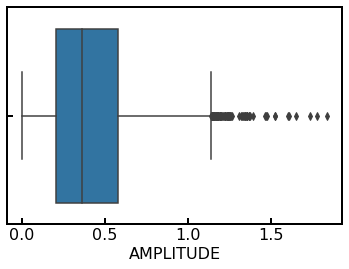

In [294]:
sns.boxplot(alldata_permuted_null['AMPLITUDE'])

In [343]:
def init_null(data, nIterations=5000):
    data_null = pd.DataFrame()
    row = 0
    for iteration in range(nIterations):
        print(iteration)
        data['Stim_diff'] = data['Stim_diff'].sample(frac=1).reset_index(drop=True)
        
        subjectdata['same_category'] = subjectdata['stimulusID'].apply(category_definition) == subjectdata['shifted_stimulusID'].apply(category_definition)

        same_category = subjectdata[subjectdata['same_category'] == True].reset_index(drop=True)
        diff_category = subjectdata[subjectdata['same_category'] == False].reset_index(drop=True)
        
        amplitude_same = permute_null(same_category, nIterations)
        data_null.loc[row, 'ITERATION'] = iteration
        data_null.loc[row, 'TYPE'] = 'SAME'
        data_null.loc[row, 'AMPLITUDE'] = amplitude_same

        amplitude_diff = permute_null(diff_category, nIterations)
        row += 1
        data_null.loc[row, 'ITERATION'] = iteration
        data_null.loc[row, 'TYPE'] = 'DIFF'
        data_null.loc[row, 'AMPLITUDE'] = amplitude_diff
        row += 1
        
    return data_null

def permute_null(data, nIterations=5000):

    ## Von Mise fitting: Shape Similarity##
    init_vals = [-25, 4]
    try: 
        best_vals, covar = curve_fit(vonmise_derivative, data['Stim_diff'], data['responseError'], p0=init_vals,bounds = ([-60,2],[60,4]))
        x = np.linspace(-75, 75, 300)
        y = [vonmise_derivative(xi,best_vals[0],best_vals[1]) for xi in x]


        if x[np.argmax(y)] > 0: 
            amplitude = np.max(y)
        else: 
            amplitude = -np.max(y)
    except RuntimeError:
        print("Error - curve_fit failed")

        
    return amplitude

In [ ]:
correct_null = init_null(subjectdata, 5000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113

<AxesSubplot:xlabel='TYPE', ylabel='AMPLITUDE'>

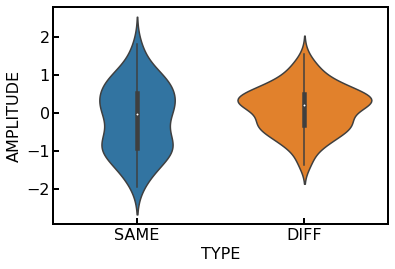

In [346]:
sns.violinplot(x='TYPE', y='AMPLITUDE', data=correct_null)